In [1]:
import pandas as pd

file_path = r"C:\Users\HR\Desktop\Workspace\데이터톤\마케팅\merged_data.csv"
df = pd.read_csv(file_path)

print(df.head())

                  event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:00+00:00       cart     5773203  1487580005134238553   
1  2019-10-01 00:00:03+00:00       cart     5773353  1487580005134238553   
2  2019-10-01 00:00:07+00:00       cart     5881589  2151191071051219817   
3  2019-10-01 00:00:07+00:00       cart     5723490  1487580005134238553   
4  2019-10-01 00:00:15+00:00       cart     5881449  1487580013522845895   

    brand  price    user_id                          user_session  \
0  runail   2.62  463240011  26dd6e6e-4dac-4778-8d2c-92e149dab885   
1  runail   2.62  463240011  26dd6e6e-4dac-4778-8d2c-92e149dab885   
2  lovely  13.48  429681830  49e8d843-adf3-428b-a2c3-fe8bc6a307c9   
3  runail   2.62  463240011  26dd6e6e-4dac-4778-8d2c-92e149dab885   
4  lovely   0.56  429681830  49e8d843-adf3-428b-a2c3-fe8bc6a307c9   

           event_time_moscow  event_month  \
0  2019-10-01 03:00:00+03:00         10.0   
1  2019-10-01 03:00:03+03:00         1

In [8]:
import pandas as pd

# CSV 또는 Parquet 파일을 불러온 뒤 df에 저장했다고 가정
# 예: df = pd.read_csv('your_file.csv') 또는 pd.read_parquet('your_file.parquet')

#  1. price가 0인 행 제거
df = df[df['price'] > 0]

#  2. brand 컬럼에서 결측치 제거
df = df.dropna(subset=['brand'])

# 결과 확인 (선택사항)
print(df.shape)
print(df['price'].min())
print(df['brand'].isnull().sum())

(11932733, 11)
0.06
0


# 브랜드별 평균 구매 금액에 차이 있다?

In [9]:
# 구매만 필터링
df_purchase = df[df['event_type'] == 'purchase'].copy()

# 브랜드별 구매 가격 데이터 준비
brand_price_data = df_purchase[['brand', 'price']].dropna()


In [10]:
from scipy.stats import f_oneway

# 브랜드별 가격 리스트 추출 (list of Series)
grouped_prices = [group['price'].values for _, group in brand_price_data.groupby('brand') if len(group) >= 30]

# ANOVA 검정
f_stat, p_val = f_oneway(*grouped_prices)
print(f"📊 F 통계량: {f_stat:.4f}, p-value: {p_val:.4e}")


📊 F 통계량: 6029.1056, p-value: 0.0000e+00


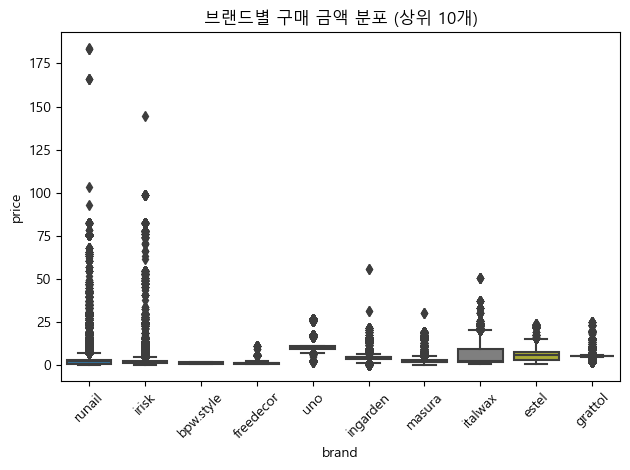

In [11]:
import matplotlib.pyplot as plt
import platform

# ✅ 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')  # 윈도우
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')    # macOS
else:
    plt.rc('font', family='NanumGothic')    # Linux / Colab

# ✅ 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


# top 브랜드 10개만 보기 (데이터 수 많은 순)
top_brands = df_purchase['brand'].value_counts().nlargest(10).index
filtered = df_purchase[df_purchase['brand'].isin(top_brands)]

sns.boxplot(data=filtered, x='brand', y='price')
plt.xticks(rotation=45)
plt.title('브랜드별 구매 금액 분포 (상위 10개)')
plt.tight_layout()
plt.show()


# 그래프 해석: 브랜드별 구매 금액 분포
    가격 분포가 확연히 다른 브랜드가 존재

    runail, irisk는 고가 제품 비중이 높고, **극단치(outliers)**도 많음

    bpw-style, feedecor는 저가 위주로, 전체 가격이 아주 낮은 편

    **중간값(median)**과 IQR(중앙 50%)을 기준으로도 브랜드 간 차이 명확

    italwax, grattol, masura는 중간가

    runail은 최고가 중심 브랜드

    위에서 진행한 ANOVA 분석과 일치

    통계적으로도 브랜드 간 구매 금액 차이가 유의미했고

    시각적으로도 명확한 가격대 차이가 보임

# ✅결론
    ANOVA 결과 :

        F 통계량 = 6029.11
        p-value < 0.0001
        👉 통계적으로 유의미한 차이 존재

    boxplot 시각화
    👉 브랜드마다 가격 분포 다름
    👉 고가 브랜드 (runail, irisk) / 저가 브랜드 (bpw-style, feedecor) 구분 명확

## ✅ "브랜드별 평균 구매 금액에 차이가 있다"


## 가장 차이가 큰 브랜드 조합

In [12]:
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Tukey HSD
tukey = pairwise_tukeyhsd(endog=brand_price_data['price'],
                          groups=brand_price_data['brand'],
                          alpha=0.05)

print(tukey.summary())


          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2     meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------
     airnails         almea   22.2772    0.0   19.8771   24.6773   True
     airnails        andrea      2.64    1.0   -9.0906   14.3705  False
     airnails        ardell    3.4745    0.0    2.4301     4.519   True
     airnails      arganoil    11.742  0.214   -1.1073   24.5913  False
     airnails    art-visage   -0.0568    1.0   -0.6081    0.4945  False
     airnails         artex    6.5134    0.0    5.7408     7.286   True
     airnails          aura    3.6263 0.0018    0.4749    6.7776   True
     airnails         avene   15.9066    0.0   12.1526   19.6606   True
     airnails      babyliss   58.1791    0.0   53.7864   62.5717   True
     airnails      balbcare    0.2516    1.0   -1.3277     1.831  False
     airnails        barbie      2.54    1.0   -11.825    16.905

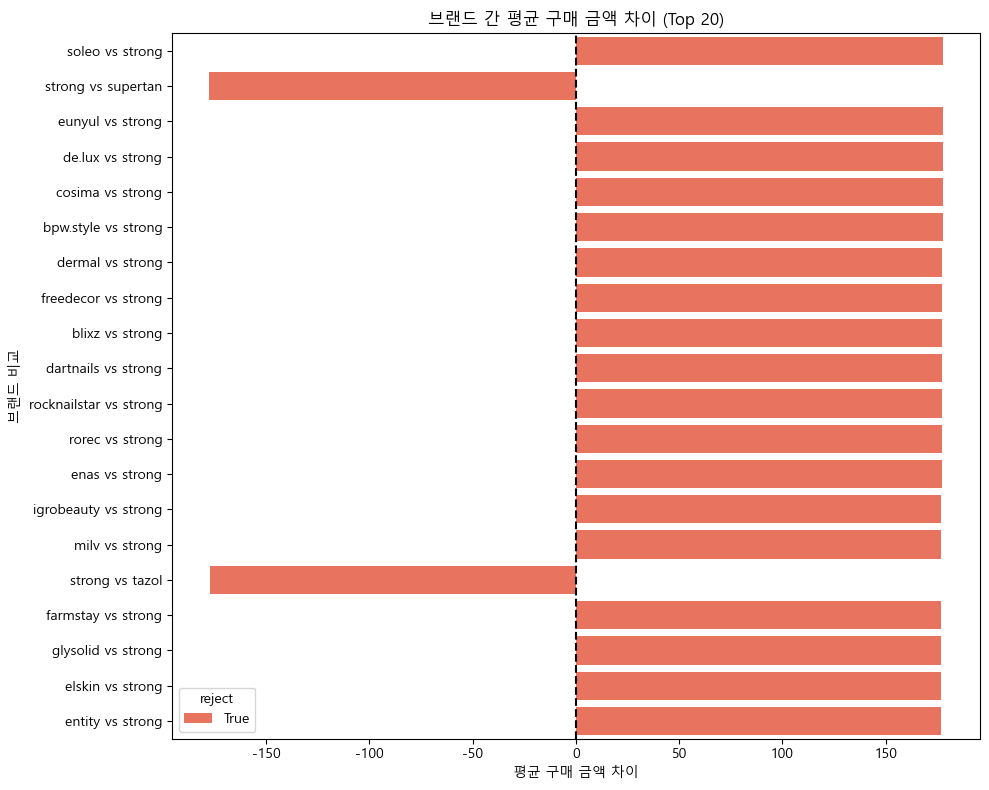

In [17]:
# Tukey 결과를 DataFrame으로 정리
import pandas as pd

tukey_df = pd.DataFrame(tukey._results_table.data[1:], columns=tukey._results_table.data[0])
tukey_df['meandiff'] = tukey_df['meandiff'].astype(float)
tukey_df['p-adj'] = tukey_df['p-adj'].astype(float)

# 평균 차이 절댓값 기준으로 상위 20개 추출
top20 = tukey_df.reindex(tukey_df['meandiff'].abs().sort_values(ascending=False).index).head(20)

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.barplot(
    data=top20,
    y=top20['group1'] + ' vs ' + top20['group2'],
    x='meandiff',
    hue='reject',
    dodge=False,
    palette={True: 'tomato', False: 'gray'}
)
plt.axvline(x=0, color='black', linestyle='--')
plt.title('브랜드 간 평균 구매 금액 차이 (Top 20)')
plt.xlabel('평균 구매 금액 차이')
plt.ylabel('브랜드 비교')
plt.tight_layout()
plt.show()



# ✅결과 해석 요약
    1. strong 브랜드가 전반적으로 가장 낮은 구매 금액을 보이고 있음
    모든 쌍이 "~ vs strong" 형식 → 비교 대상이 대부분 strong
    평균 차이가 +150 이상인 경우가 많음 → strong이 매우 저가 브랜드

    2. 가장 큰 금액 차이 브랜드 쌍
    soleo vs strong → 평균 구매 금액 차이 약 170 이상
    strong vs supertan, eunyul vs strong, de.lux vs strong 등도 모두 +150 이상 차이
📌 위 브랜드들은 high-end (고가) 제품일 가능성 큼

    3. 모든 막대가 reject=True
    → 이 Top 20 쌍은 모두 통계적으로 유의미한 가격 차이가 있다

# 특정 브랜드는 반복 구매가 많다?

In [20]:
# 구매 데이터만 사용
df_purchase = df[df['event_type'] == 'purchase'].copy()

# 유저-브랜드 기준으로 구매 횟수 집계
brand_repeat = df_purchase.groupby(['brand', 'user_key']).size().reset_index(name='purchase_count')


In [21]:
brand_avg_repeat = brand_repeat.groupby('brand')['purchase_count'].mean().reset_index()
brand_avg_repeat.columns = ['brand', 'avg_repeat_count']


In [22]:
from scipy.stats import f_oneway

# 구매 유저 수가 적은 브랜드는 제거 (신뢰도 확보)
filtered = brand_repeat.groupby('brand').filter(lambda x: len(x) >= 30)

# 브랜드별 리스트로 나눔
repeat_groups = [group['purchase_count'].values for _, group in filtered.groupby('brand')]

# ANOVA 실행
f_stat, p_val = f_oneway(*repeat_groups)
print(f"📊 F 통계량: {f_stat:.4f}, p-value: {p_val:.4e}")


📊 F 통계량: 103.0218, p-value: 0.0000e+00


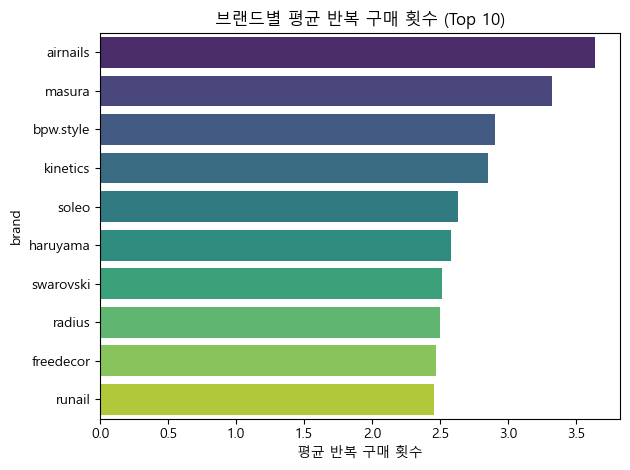

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

top_brands = brand_avg_repeat.sort_values('avg_repeat_count', ascending=False).head(10)

sns.barplot(data=top_brands, x='avg_repeat_count', y='brand', palette='viridis')
plt.title('브랜드별 평균 반복 구매 횟수 (Top 10)')
plt.xlabel('평균 반복 구매 횟수')
plt.tight_layout()
plt.show()


# ✅결론
    p-value < 0.05이므로 👉 브랜드별 평균 반복 구매 횟수에는 통계적으로 유의한 차이가 있음
    즉, 특정 브랜드는 재구매가 많다는 가설은 지지됨!

## ✅그래프 인사이트
    airnails, masura, bpw.style는 평균 3회 이상 반복 구매
    반면 runail, freedecor는 상대적으로 낮음 (2회 언저리)
    즉, airnails는 충성도 높은 고객이 많은 브랜드라고 해석 가능



# 일부 제품은 높은 view 대비 낮은 구매율을 보인다?

In [26]:
# View / Purchase만 필터링
df_view = df[df['event_type'] == 'view']
df_purchase = df[df['event_type'] == 'purchase']

# 제품별 user 수
view_counts = df_view.groupby('product_id')['user_key'].nunique().reset_index(name='view_count')
purchase_counts = df_purchase.groupby('product_id')['user_key'].nunique().reset_index(name='purchase_count')

# 병합 후 전환율 계산
product_funnel = pd.merge(view_counts, purchase_counts, on='product_id', how='left')
product_funnel['purchase_count'] = product_funnel['purchase_count'].fillna(0)

# 구매 전환율 계산
product_funnel['conversion_rate'] = product_funnel['purchase_count'] / product_funnel['view_count']


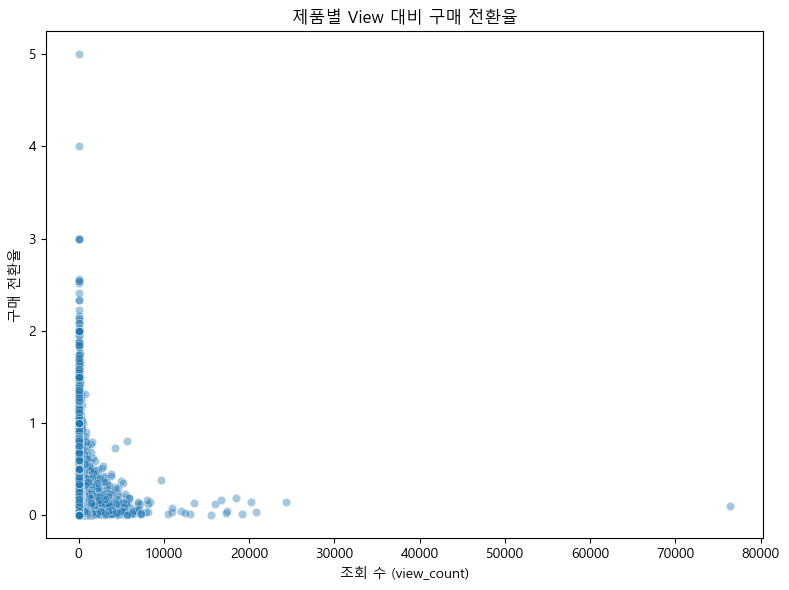

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(data=product_funnel, x='view_count', y='conversion_rate', alpha=0.4)
plt.title("제품별 View 대비 구매 전환율")
plt.xlabel("조회 수 (view_count)")
plt.ylabel("구매 전환율")
plt.tight_layout()
plt.show()


In [28]:
# 조회수 상위 5% 제품 중 구매율 낮은 제품 보기
top_view = product_funnel[product_funnel['view_count'] >= product_funnel['view_count'].quantile(0.95)]
low_conv = top_view.sort_values('conversion_rate').head(10)

print(low_conv[['product_id', 'view_count', 'purchase_count', 'conversion_rate']])


       product_id  view_count  purchase_count  conversion_rate
1507        59872         695             0.0         0.000000
27468     5906219         978             0.0         0.000000
1050        27759        1604             0.0         0.000000
8822      5770134         773             0.0         0.000000
1064        27845         802             0.0         0.000000
8926      5771614        3075             2.0         0.000650
8569      5767004        1251             1.0         0.000799
5601      5700855        1237             1.0         0.000808
8620      5768982        1159             1.0         0.000863
29044     5915337        5643             5.0         0.000886


# 결론
    ✅ 조회수가 수천 회 이상인 제품들인데도
    -> 구매 수가 0~5건, 전환율은 0~0.08% 수준

# 시각화 해석
    대부분의 제품은 조회수 대비 전환율이 매우 낮음
    특히 조회 수가 클수록 전환율이 0에 가까운 점들이 다수 존재
    0에 수렴하는 점들이 수평선처럼 몰려 있음 → 이탈 제품 존재 명확

# 카테고리별로 이탈률 차이가 있다?

In [33]:
# 장바구니 담기 수
cart = df[df['event_type'] == 'cart'].groupby('category_id')['user_key'].nunique().reset_index(name='cart_count')

# 장바구니 이탈 수
remove = df[df['event_type'] == 'remove_from_cart'].groupby('category_id')['user_key'].nunique().reset_index(name='remove_count')

# 병합 및 이탈률 계산
category_funnel = pd.merge(cart, remove, on='category_id', how='left')
category_funnel['remove_count'] = category_funnel['remove_count'].fillna(0)
category_funnel['remove_rate'] = category_funnel['remove_count'] / category_funnel['cart_count']


In [34]:
# 유저-카테고리 기준으로 구매 행동 집계
df_cart = df[df['event_type'] == 'cart']
df_remove = df[df['event_type'] == 'remove_from_cart']

# 유저별 행동 수
cart_user = df_cart.groupby(['category_id', 'user_key']).size().reset_index(name='cart_count')
remove_user = df_remove.groupby(['category_id', 'user_key']).size().reset_index(name='remove_count')

# 병합
user_funnel = pd.merge(cart_user, remove_user, on=['category_id', 'user_key'], how='left')
user_funnel['remove_count'] = user_funnel['remove_count'].fillna(0)

# 유저 기준 이탈률
user_funnel['remove_rate'] = user_funnel['remove_count'] / user_funnel['cart_count']


In [35]:
from scipy.stats import f_oneway

# 관측 수가 적은 카테고리는 제거 (ex: 30명 이상만)
filtered = user_funnel.groupby('category_id').filter(lambda x: len(x) >= 30)

# 카테고리별 리스트로 분리
groups = [group['remove_rate'].values for _, group in filtered.groupby('category_id')]

# ANOVA 실행
f_stat, p_val = f_oneway(*groups)
print(f"📊 F 통계량: {f_stat:.4f}, p-value: {p_val:.4e}")


📊 F 통계량: 25.7311, p-value: 0.0000e+00


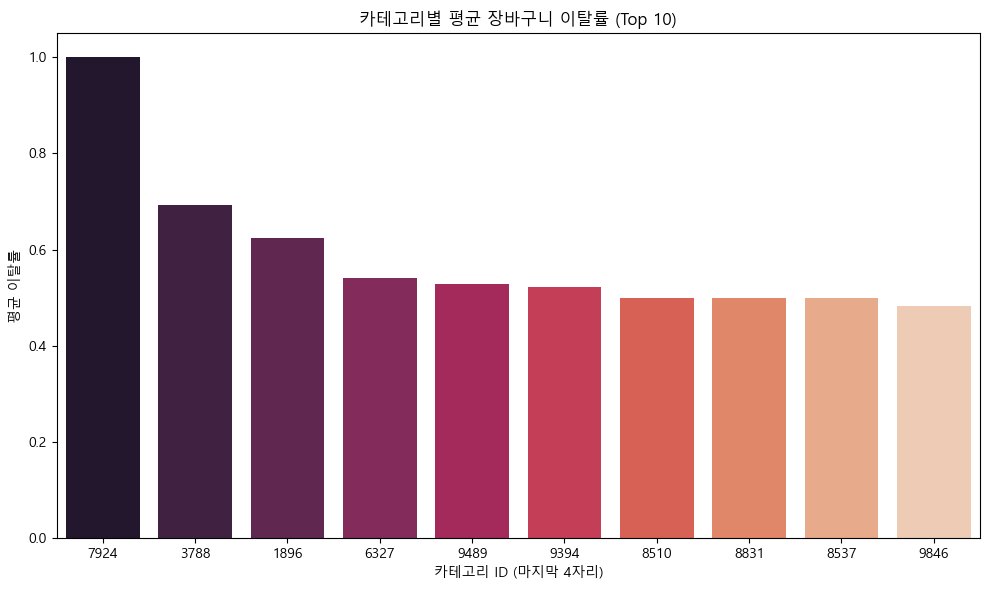

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1. 카테고리별 평균 이탈률 계산
category_mean = user_funnel.groupby('category_id')['remove_rate'].mean().reset_index()

# Step 2. 상위 10개 추출
top10 = category_mean.sort_values('remove_rate', ascending=False).head(10).copy()

# Step 3. 보기 좋은 라벨 만들기 (뒤 4자리만 활용 or 문자열 변환)
top10['category_label'] = top10['category_id'].astype(str).str[-4:]

# Step 4. 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=top10, x='category_label', y='remove_rate', palette='rocket')

plt.title("카테고리별 평균 장바구니 이탈률 (Top 10)")
plt.xlabel("카테고리 ID (마지막 4자리)")
plt.ylabel("평균 이탈률")
plt.tight_layout()
plt.show()



# 분석 결과
         ANOVA 결과
    F 통계량: 25.7311
    p-value: 0.0000 → 통계적으로 매우 유의미한 차이 있음
    카테고리별 이탈률은 단순 우연이 아닌, 실질적인 차이를 보임

        시각화 (Top 10 카테고리별 평균 이탈률)
    이탈률이 **가장 높은 카테고리 (ID 끝자리 7924)**는 이탈률 1.0 (100%)
    → 장바구니에 담기긴 하지만 전부 제거됨
    -다른 상위 카테고리들도 0.5~0.7 수준의 높은 이탈률 보임
    -하위 카테고리는 0.4 근처로 상대적으로 안정적

    ✅ 최종 결론
 **“카테고리별 장바구니 이탈률에는 유의미한 차이가 있다”**는 가설은
    통계적으로, 시각적으로 모두 지지된다.